### TODO

- Cluster by point at which 100 thereafter
- K-means cluster
    - How consistent are clusters across different random initialisations of cluster centers?
- Do with mean F1 across seeds
- Do individually for all seeds and see if clusters are similar
- Look at examples inside cluster
- Look dataset distribution in each cluster

In [27]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
os.chdir('../..')

In [111]:
from src.analysis.per_example_metrics import load_adversarial_dev_as_df

In [3]:
SEEDS = [27, 28, 29]
MODELS = ['dbert', 'dbidaf', 'droberta']  #, 'squad']

In [4]:
example_metric_df = pd.DataFrame()

for seed in SEEDS:
    for model in MODELS:
        df = pd.read_csv(f'data/processed/per_example_metrics-squadv1-adversarialall-dataset={model}-seed={seed}.csv')
        print(df.shape)
        example_metric_df = example_metric_df.append(df)
        
print(example_metric_df.shape)
example_metric_df.head()

(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(120000, 6)
(1080000, 6)


,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [5]:
example_metric_df['dataset'].value_counts()

dbidaf      360000
dbert       360000
droberta    360000
Name: dataset, dtype: int64

Verify that taking mean score over examples matches metrics in JSON

In [9]:
np.random.seed(3)
example_metric_df.groupby(['checkpoint', 'dataset', 'seed']).mean().sample(n=5)

,,,exact_match,f1
checkpoint,dataset,seed,,
620,dbidaf,28,45.5,60.537007
5004,droberta,28,41.0,51.416354
332,dbidaf,28,40.7,53.994171
972,droberta,28,27.7,38.317959
1004,dbert,29,36.8,49.884105


## K-means clustering

Take mean F1 for each example across seeds

In [10]:
example_metric_df.head()

,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [11]:
example_metric_mean_df = example_metric_df.groupby(['id', 'checkpoint', 'dataset']).mean().reset_index()
example_metric_mean_df.drop('seed', axis=1, inplace=True)
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 5)


,id,checkpoint,dataset,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667


In [12]:
example_metric_mean_df['id'].nunique()

3000

In [13]:
example_metric_mean_df.groupby('dataset').nunique()

,id,checkpoint,exact_match,f1
dataset,,,,
dbert,1000,120,4,4333
dbidaf,1000,120,4,3866
droberta,1000,120,4,4412


Input, `X`, for `TimeSeriesKMeans` needs to be of dim (`n_ts`, `sz`, `d`)

`n_ts` - Number of time series.

`sz` - Length of time series (number of time instants).

`d` - Dimensionality of time series.

Construct X

In [14]:
example_metric_mean_df.shape

(360000, 5)

In [15]:
example_metric_mean_df.head()

,id,checkpoint,dataset,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667


In [16]:
n_ts = example_metric_mean_df['id'].nunique()
sz = 120
d = 1

X = np.zeros((n_ts, sz, d))

In [17]:
example_metric_mean_df.sort_values(['id', 'checkpoint'], inplace=True)

# Store mapping for index position to corresponding ID
idx_to_id_dict = {}

for idx, _id in tqdm(
    enumerate(example_metric_mean_df['id'].unique()),
    total=example_metric_mean_df['id'].nunique()
):
    
    idx_to_id_dict[idx] = _id
    
    X[idx, :, :] = example_metric_mean_df[example_metric_mean_df['id'] == _id]['f1'].values.reshape(-1, 1)

100%|██████████| 3000/3000 [00:52<00:00, 56.80it/s]


Check example

In [26]:
np.random.seed(3)

test_id = example_metric_mean_df['id'].sample(n=1).item()

reverse_dict = {v: k for k, v in idx_to_id_dict.items()}

np.testing.assert_array_equal(
    X[reverse_dict[test_id], :, :], 
    example_metric_mean_df[example_metric_mean_df['id'] == test_id]['f1'].values.reshape(-1, 1)
)

### 3 clusters

In [33]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=300, random_state=0, verbose=0, n_jobs=-1)

In [34]:
%%time
labels = km.fit_predict(X)

CPU times: user 5min 40s, sys: 59 s, total: 6min 39s
Wall time: 2min 56s


In [36]:
km.n_iter_

12

In [35]:
labels

array([0, 2, 1, ..., 0, 2, 1])

In [37]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [38]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,0
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,2
2,00245d3e103a58ff1e76c4996721a03a70412422,1
3,004241bb0375392cd909e85aeedbdf9b2f899def,1
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0


In [39]:
id_KMlabels_df['KM_label'].value_counts()

0    1664
2     699
1     637
Name: KM_label, dtype: int64

In [40]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0


In [44]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.060096,3.387846
1,1,1,0.104657,4.634967
2,1,2,0.095374,4.496766
3,2,0,0.060096,3.414916
4,2,1,0.104657,4.666946


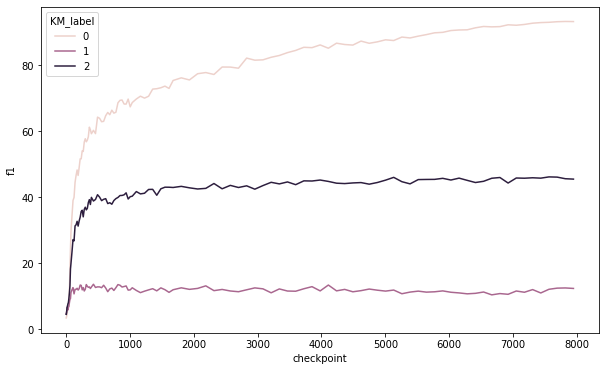

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label'
)
plt.show()

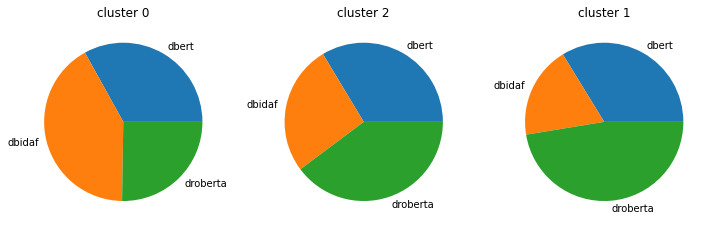

In [68]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(10, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

### 5 clusters

In [72]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=300, random_state=0, verbose=0, n_jobs=-1)

In [73]:
%%time
labels = km.fit_predict(X)

CPU times: user 8min 48s, sys: 1min 28s, total: 10min 16s
Wall time: 3min 47s


In [74]:
km.n_iter_

15

In [75]:
labels

array([0, 0, 1, ..., 3, 2, 1])

In [76]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [77]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,0
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,0
2,00245d3e103a58ff1e76c4996721a03a70412422,1
3,004241bb0375392cd909e85aeedbdf9b2f899def,1
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,4


In [78]:
id_KMlabels_df['KM_label'].value_counts()

3    769
1    590
0    567
4    545
2    529
Name: KM_label, dtype: int64

In [79]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0


In [80]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.058789,3.872139
1,1,1,0.056497,4.607523
2,1,2,0.126024,4.918993
3,1,3,0.086693,2.788580
4,1,4,0.061162,3.802904


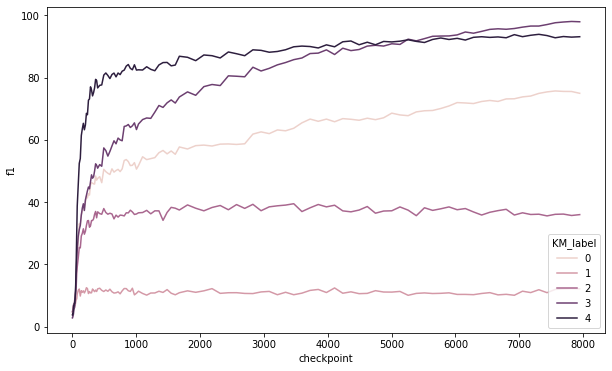

In [81]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label'
)
plt.show()

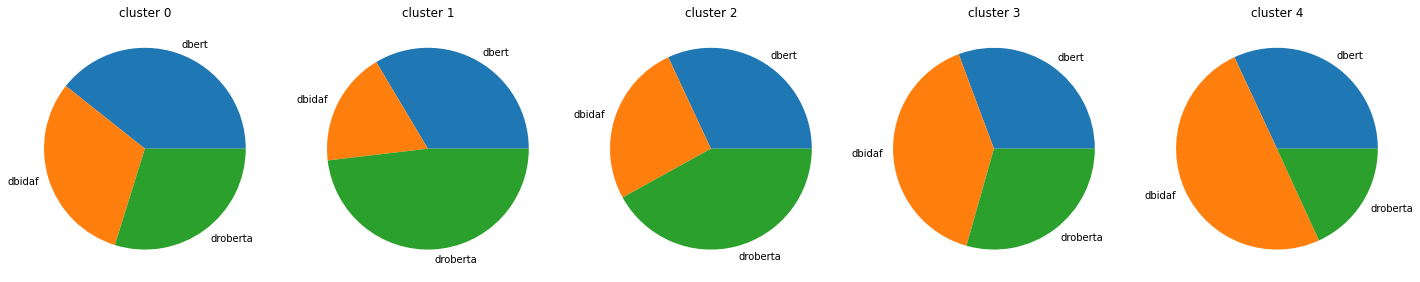

In [84]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(20, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

### 10 clusters

In [85]:
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=300, random_state=0, verbose=0, n_jobs=-1)

In [86]:
%%time
labels = km.fit_predict(X)

CPU times: user 16min 42s, sys: 2min 49s, total: 19min 32s
Wall time: 6min 15s


In [87]:
km.n_iter_

20

In [88]:
labels

array([0, 7, 1, ..., 4, 3, 9])

In [89]:
id_KMlabels = []
for idx, _id in idx_to_id_dict.items():
    id_KMlabels.append((_id, labels[idx]))

In [90]:
id_KMlabels_df = pd.DataFrame(id_KMlabels, columns=['id', 'KM_label'])
print(id_KMlabels_df.shape)
id_KMlabels_df.head()

(3000, 2)


,id,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,0
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,7
2,00245d3e103a58ff1e76c4996721a03a70412422,1
3,004241bb0375392cd909e85aeedbdf9b2f899def,9
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2


In [91]:
id_KMlabels_df['KM_label'].value_counts()

2    604
8    404
4    399
5    326
1    301
9    296
7    238
6    182
0    134
3    116
Name: KM_label, dtype: int64

In [92]:
plot_df = example_metric_mean_df.merge(id_KMlabels_df, on='id')
print(plot_df.shape)
plot_df.head()

(360000, 6)


,id,checkpoint,dataset,exact_match,f1,KM_label
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0


In [93]:
plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index().head()

,checkpoint,KM_label,exact_match,f1
0,1,0,0.497512,3.949970
1,1,1,0.000000,4.291581
2,1,2,0.055188,3.232755
3,1,3,0.000000,4.297672
4,1,4,0.167084,5.121328


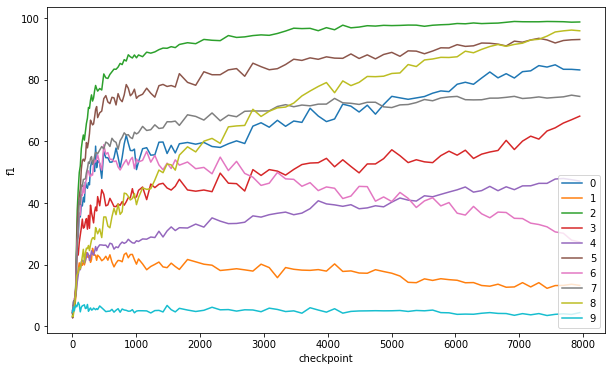

In [106]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df.groupby(['checkpoint', 'KM_label']).mean().reset_index(), 
    x='checkpoint', 
    y='f1', 
    hue='KM_label',
    legend='full',
    palette='tab10'
)
plt.legend()
plt.show()

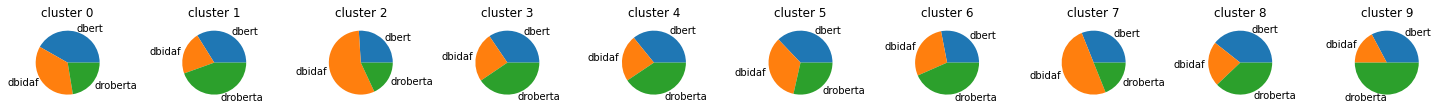

In [104]:
fig, axs = plt.subplots(1, plot_df['KM_label'].nunique(), figsize=(20, 5*plot_df['KM_label'].nunique()))

for i, label in enumerate(np.sort(plot_df['KM_label'].unique())):
    axs[i].pie(
        x=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['id'],
        labels=plot_df[plot_df['KM_label'] == label].groupby('dataset')['id'].count().reset_index()['dataset']
    )
    axs[i].set_title(f'cluster {label}')
plt.tight_layout()
plt.show()

100%|██████████| 182/182 [00:01<00:00, 100.22it/s]


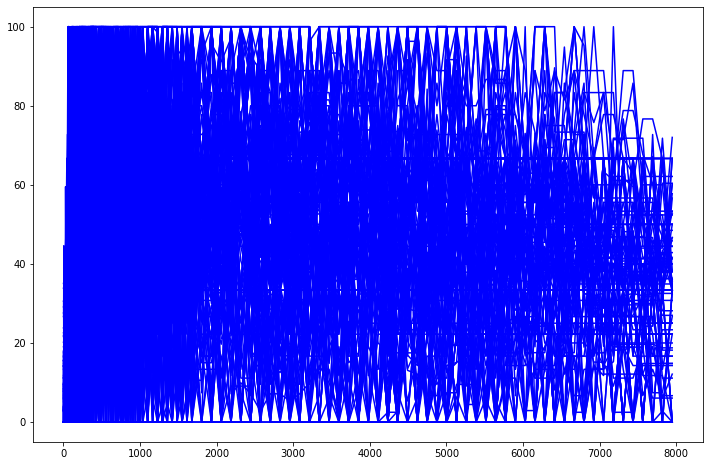

In [110]:
plt.figure(figsize=(12, 8))
for _id in tqdm(plot_df[plot_df['KM_label'] == 6]['id'].unique()):
    plt.plot(
        plot_df[plot_df['KM_label'] == 6][plot_df[plot_df['KM_label'] == 6]['id'] == _id]['checkpoint'],
        plot_df[plot_df['KM_label'] == 6][plot_df[plot_df['KM_label'] == 6]['id'] == _id]['f1'],
        color='blue'
    )
plt.show()

In [115]:
adversarial_qa_labels = pd.DataFrame()

for model in MODELS:
    df = load_adversarial_dev_as_df(model)
    adversarial_qa_labels = adversarial_qa_labels.append(df)

2021-08-05 01:15:23,897 - Loading dbert dev data as DataFrame
2021-08-05 01:15:24,363 - Reusing dataset adversarial_qa (/Users/stevengeorge/.cache/huggingface/datasets/adversarial_qa/dbert/1.0.0/2f8c1f6e146e203b3fde4b73427f19abf4ab44f315df4ccd7613f03caf3c2971)
2021-08-05 01:15:24,462 - (1000, 6)
2021-08-05 01:15:24,462 -                                              answers  \
0  {'answer_start': [101], 'text': ['average prof...   
1  {'answer_start': [185], 'text': ['anxiety, dep...   
2    {'answer_start': [123], 'text': ['2012 study']}   
3  {'answer_start': [121], 'text': ['A 2012 study']}   
4              {'answer_start': [3], 'text': ['US']}   

                                             context  \
0  A 2000 study found that 42% of UK teachers exp...   
1  A 2000 study found that 42% of UK teachers exp...   
2  A 2000 study found that 42% of UK teachers exp...   
3  A 2000 study found that 42% of UK teachers exp...   
4  30 US states have banned corporal punishment, ...   

   

In [116]:
adversarial_qa_labels.shape

(3000, 6)

In [117]:
adversarial_qa_labels['id'].nunique()

3000

In [122]:
plot_df_with_labels = plot_df.merge(adversarial_qa_labels, on='id')
plot_df_with_labels.head()

,id,checkpoint,dataset,exact_match,f1,KM_label,answers,context,metadata,question,title
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,0.0,4.166667,0,"{'answer_start': [102], 'text': ['pilgrimage']}",Luther dedicated himself to the Augustinian or...,"{'split': 'validation', 'model_in_the_loop': '...",Martin Luther once he was dedicated to the Aug...,Martin_Luther


In [128]:
np.random.seed(3)

for _, row in plot_df_with_labels[plot_df_with_labels['KM_label'] == 6].sample(n=5).iterrows():
    print(row['id'])
    print(row['context'])
    print(row['question'])
    print('\n')

9fb0e5e03a5c05b4e7d1c6b97ac34abb435b2d90
In late November 2015, reports surfaced stating that "multiple acts" would perform during the halftime show. On December 3, the league confirmed that the show would be headlined by the British rock group Coldplay. On January 7, 2016, Pepsi confirmed to the Associated Press that Beyoncé, who headlined the Super Bowl XLVII halftime show and collaborated with Coldplay on the single "Hymn for the Weekend", would be making an appearance. Bruno Mars, who headlined the Super Bowl XLVIII halftime show, and Mark Ronson also performed.
Who headlined Super Bowl 48?


71fb2a94a984342827805dbb12ea03f9d4acf7c9
Luther spoke out against the Jews in Saxony, Brandenburg, and Silesia. Josel of Rosheim, the Jewish spokesman who tried to help the Jews of Saxony in 1537, later blamed their plight on "that priest whose name was Martin Luther—may his body and soul be bound up in hell!—who wrote and issued many heretical books in which he said that whoever would help th

## Other stuff

In [6]:
example_metric_mean_df = example_metric_df.groupby(['id', 'checkpoint', 'dataset']).mean().reset_index()
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 6)


,id,checkpoint,dataset,seed,exact_match,f1
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,28,0.0,4.166667
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,28,0.0,4.166667
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,28,0.0,4.166667
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,28,0.0,4.166667
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,28,0.0,4.166667


In [7]:
example_metric_mean_df['id'].nunique()

3000

In [8]:
example_metric_mean_df.groupby('dataset').nunique()

,id,checkpoint,seed,exact_match,f1
dataset,,,,,
dbert,1000,120,1,4,4333
dbidaf,1000,120,1,4,3866
droberta,1000,120,1,4,4412


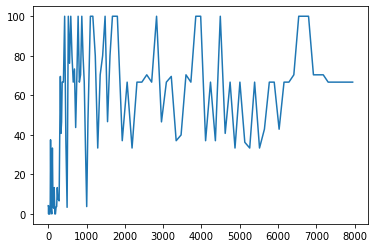

In [9]:
plt.plot(
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['checkpoint'],
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['f1']
)

In [10]:
example_metric_mean_df.shape

(360000, 6)

In [11]:
example_metric_mean_df[example_metric_mean_df['f1'] == 100]['checkpoint'].describe()

count    72480.000000
mean      3721.754636
std       2519.294627
min         52.000000
25%       1164.000000
50%       3724.000000
75%       6028.000000
max       7948.000000
Name: checkpoint, dtype: float64

In [12]:
example_metric_mean_df[example_metric_mean_df['id'] == '000bcf40cda48527886c945b612c0c54ed46dff8']['f1'].diff()

0      NaN
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
Name: f1, Length: 120, dtype: float64

In [13]:
example_metric_mean_df.groupby('id').mean()['f1'].max()

87.77777777777779

In [14]:
finish_on_100 = example_metric_mean_df[(example_metric_mean_df['checkpoint'] == 7948) & (example_metric_mean_df['f1'] == 100)][['id']].reset_index(drop=True)
finish_on_100['finish_on_100'] = 1
print(finish_on_100.shape)
finish_on_100.head()

(1207, 2)


,id,finish_on_100
0,0054d06bf3be61edaa33f71cf897f98a37e73ea8,1
1,00b4f6a5f86df49f018c808959a6c010ef344ec3,1
2,014b21e6cca775f8d8d46f27b64a7d9e4f43dd7c,1
3,014b4f904d0dc326b0fe559497047324e21884a6,1
4,015917de773ce636b02c024fbc3f2a17b471f010,1


In [15]:
example_metric_mean_df = example_metric_mean_df.merge(finish_on_100, how='left', on='id')
example_metric_mean_df['finish_on_100'].fillna(0, inplace=True)
print(example_metric_mean_df.shape)
example_metric_mean_df.head()

(360000, 7)


,id,checkpoint,dataset,seed,exact_match,f1,finish_on_100
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,dbidaf,28,0.0,4.166667,0.0
1,000bcf40cda48527886c945b612c0c54ed46dff8,2,dbidaf,28,0.0,4.166667,0.0
2,000bcf40cda48527886c945b612c0c54ed46dff8,3,dbidaf,28,0.0,4.166667,0.0
3,000bcf40cda48527886c945b612c0c54ed46dff8,4,dbidaf,28,0.0,4.166667,0.0
4,000bcf40cda48527886c945b612c0c54ed46dff8,5,dbidaf,28,0.0,4.166667,0.0


In [16]:
finish_on_100 = example_metric_mean_df[example_metric_mean_df['finish_on_100'] == 1]
print(finish_on_100.shape)
finish_on_100.head()

(144840, 7)


,id,checkpoint,dataset,seed,exact_match,f1,finish_on_100
480,0054d06bf3be61edaa33f71cf897f98a37e73ea8,1,dbidaf,28,0.0,13.333333,1.0
481,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2,dbidaf,28,0.0,13.333333,1.0
482,0054d06bf3be61edaa33f71cf897f98a37e73ea8,3,dbidaf,28,0.0,13.333333,1.0
483,0054d06bf3be61edaa33f71cf897f98a37e73ea8,4,dbidaf,28,0.0,13.333333,1.0
484,0054d06bf3be61edaa33f71cf897f98a37e73ea8,5,dbidaf,28,0.0,13.333333,1.0


100%|██████████| 1207/1207 [00:18<00:00, 64.53it/s]


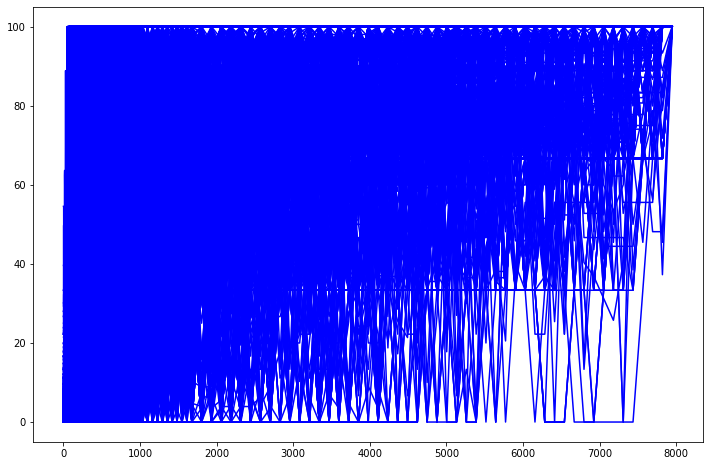

In [17]:
plt.figure(figsize=(12, 8))
for _id in tqdm(finish_on_100['id'].unique()):
    plt.plot(
        finish_on_100[finish_on_100['id'] == _id]['checkpoint'],
        finish_on_100[finish_on_100['id'] == _id]['f1'],
        color='blue'
    )
plt.show()

In [18]:
finish_on_100.drop('seed', inplace=True, axis=1)
finish_on_100.sort_values(['id', 'checkpoint'], ascending=False, inplace=True)
finish_on_100.head()

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,checkpoint,dataset,exact_match,f1,finish_on_100
359279,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7948,droberta,100.000000,100.000000,1.0
359278,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7820,droberta,66.666667,71.794872,1.0
359277,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7692,droberta,100.000000,100.000000,1.0
359276,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7564,droberta,66.666667,71.794872,1.0
359275,fee314c7a0a0c88baab26254ccb6bd3016a8400c,7436,droberta,33.333333,38.461538,1.0


In [19]:
finish_on_100['diff'] = finish_on_100.groupby(['id'])['f1'].diff()

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
finish_on_100['diff'].fillna(0, inplace=True)

/Users/stevengeorge/opt/anaconda3/envs/rclearn/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [21]:
chkpt_100_thereafter = finish_on_100[finish_on_100['diff'] != 0].groupby('id')['checkpoint'].max().reset_index()
print(chkpt_100_thereafter.shape)
chkpt_100_thereafter.head()

(1207, 2)


,id,checkpoint
0,0054d06bf3be61edaa33f71cf897f98a37e73ea8,2188
1,00b4f6a5f86df49f018c808959a6c010ef344ec3,6284
2,014b21e6cca775f8d8d46f27b64a7d9e4f43dd7c,3084
3,014b4f904d0dc326b0fe559497047324e21884a6,5132
4,015917de773ce636b02c024fbc3f2a17b471f010,396


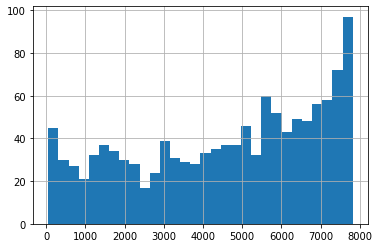

In [22]:
chkpt_100_thereafter['checkpoint'].hist(bins=30)
plt.show()

In [23]:
chkpt_100_thereafter.describe()

,checkpoint
count,1207.000000
mean,4562.223695
std,2338.467682
min,52.000000
25%,2700.000000
50%,5004.000000
75%,6604.000000
max,7820.000000


In [24]:
chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values

array(['069b1721a0d8face50835e9c2d387d669f855d34',
       '17408941318fb9c79bcfe8ce2c14cd0abdca46d4',
       '3904cd560e47bfef8a77eedea659e773d9899761',
       '425c26a9f94ac7f2c09a173a8101b63a2fbff509',
       '43b0aedaf9efe9f7c2c23aa998c22aa9872f5a2c',
       '575e873aafa3801bb3f700df33b36ab1b2fcac31',
       '5980585b3df621a1c705bfc2cac4d4c35e7b1c8f',
       '7a91e42d951791eb45d2f580bdfcf5b5afe888e3',
       '8005c14e861b8a6e81ec9e235e580117a54b39fd',
       '97e723e3d467c4adf25f5a2e1ed2d388063c7349',
       '998a85bf35193719ce4c63c57eda0dc001818b4b',
       '9c14d41d3fee9df93dc80aab1941977ee6e3c2a4',
       '9d4b0f20a55f80bf9bc2a35618a929789a2e58c4',
       'af9e58180ad94b3fc5682657366a312c8ff8e87b',
       'b407409dd3fea2022ba487aa9f451a9577386cd5',
       'be11dc4533d50d5ee7e30995ef8c28a064c9a8fc',
       'c4c25f3cba310af0d3ffa5cabf10f012b1e1a3e3',
       'dc15a9693507511987169dcf0b8d1aaed73fc92d',
       'de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f'], dtype=object)

In [25]:
finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]

,id,checkpoint,dataset,exact_match,f1,finish_on_100,diff
312359,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7948,droberta,100.0,100.00000,1.0,0.000000
312358,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7820,droberta,100.0,100.00000,1.0,0.000000
312357,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7692,droberta,100.0,100.00000,1.0,0.000000
312356,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7564,droberta,100.0,100.00000,1.0,0.000000
312355,de3f03f2dbac7e6ca57c09b37c98076ddc6dd41f,7436,droberta,100.0,100.00000,1.0,0.000000
...,...,...,...,...,...,...,...
10804,069b1721a0d8face50835e9c2d387d669f855d34,5,dbidaf,0.0,9.76431,1.0,3.703704
10803,069b1721a0d8face50835e9c2d387d669f855d34,4,dbidaf,0.0,9.76431,1.0,0.000000
10802,069b1721a0d8face50835e9c2d387d669f855d34,3,dbidaf,0.0,9.76431,1.0,0.000000
10801,069b1721a0d8face50835e9c2d387d669f855d34,2,dbidaf,0.0,9.76431,1.0,0.000000


100%|██████████| 19/19 [00:00<00:00, 38.18it/s]


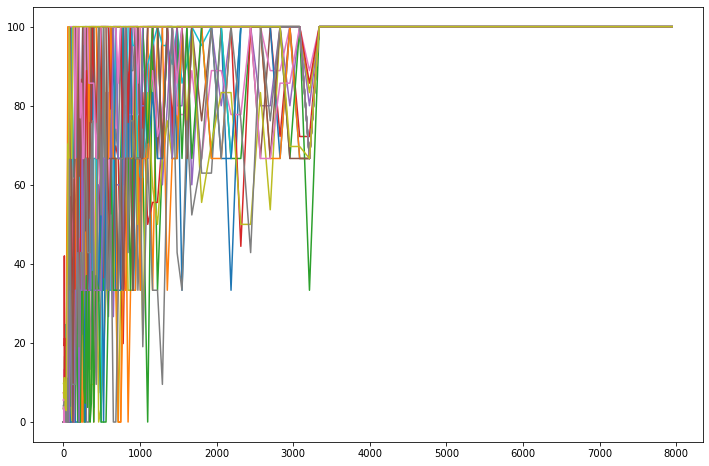

In [26]:
plt.figure(figsize=(12, 8))
for _id in tqdm(finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'].unique()):
    plt.plot(
        finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)][finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'] == _id]['checkpoint'],
        finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)][finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)]['id'] == _id]['f1'],
    )
plt.show()

<AxesSubplot:xlabel='checkpoint'>

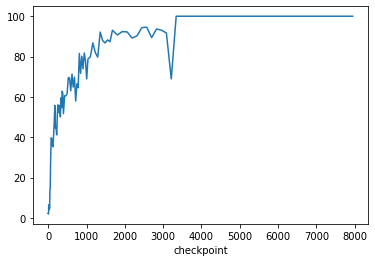

In [27]:
finish_on_100[finish_on_100['id'].isin(chkpt_100_thereafter[chkpt_100_thereafter['checkpoint'] == 3212]['id'].values)].groupby('checkpoint').mean()['f1'].plot()

In [ ]:
plot_df.groupby()